In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 11 20:50:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Faster RCNN

## Goals:
- Training/Inference available to user
- Inference:
    - ...
- Training:
    - User submitted parameters:
        - k: number of anchors
        - pretrained network (ZF/VGG16/user submitted)
        - n: spatial window size
        - window map output dimension (ZF:256-d/VGG16:512d)
        - scale/aspect ratios of anchors
        - IoU limits (upper and lower) for flagging anchors
        - loss functions: one for Lcls, one for Lreg, one for the combination of the two
        - optimizers: one for RPN branch and one for CLS branch
        - mini-batch size of randomly sampled anchors (default 256)
        - ratio of positive to negative anchors in mini-batch (default 1:1)
        - new layer initilization functions (default Gauss 0mean, 0.01std)
        - weight initialization for the base (pretrained) model

## Components


In [4]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.0 MB/s 


In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers


import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Data:
- PASCAL VOC 2007:
    - trained on VOC 2007 trainval
    - test on testset

In [6]:
def get_original_data_with_info():
    """ Use when you need fresh voc data. 

        Returns:
            test_ds, train_ds, valid_ds, info
    """
    data, info = tfds.load("voc", with_info=True)
    test_ds, train_ds, valid_ds = data.values()
    return test_ds, train_ds, valid_ds, info
test_ds, train_ds, valid_ds, info = get_original_data_with_info()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incomplete0RQWPP/voc-test.tfrecord


  0%|          | 0/4952 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incomplete0RQWPP/voc-train.tfrecord


  0%|          | 0/2501 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incomplete0RQWPP/voc-validation.tfrecord


  0%|          | 0/2510 [00:00<?, ? examples/s]

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [7]:
print(info)
classlbls = info.features['labels']

tfds.core.DatasetInfo(
    name='voc',
    version=4.0.0,
    description='This dataset contains the data from the PASCAL Visual Object Classes Challenge
2007, a.k.a. VOC2007, corresponding to the Classification and Detection
competitions.
A total of 9963 images are included in this dataset, where each image
contains a set of objects, out of 20 different classes, making a total of
24640 annotated objects.
In the Classification competition, the goal is to predict the set of labels
contained in the image, while in the Detection competition the goal is to
predict the bounding box and label of each individual object.
annotations.',
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'labels': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20)),
        'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=t

In [8]:
def print_bbox_formats():
    """ Use when you need a reminder of the data formats. """
    print("Axis: x -> left-right; y -> up-down")
    print("Reference frame (x,y): top-left = (0,0); bot-right = (img_W,img_H)")
    print("*All values normalized b/w [0,1]*")
    print("VOC:    (ymin, xmin, ymax, xmax)")
    print("RCNN:   (center_x, center_y, width, height)")
    print("Pyplot: (xmin, ymin, width, height)")

In [9]:
def voc_to_rcnn_bbox(voc_bbox):
    """ VOC-to-RCNN bounding box format swap.
        Top-left = (0,0), Bot-right = (W-1,H-1)
        (x,y)-Axes
        
        VOC:  (ymin, xmin, ymax, xmax)
        RCNN: (center_x, center_y, width, height)
    """
    ymin, xmin, ymax, xmax = tf.split(voc_bbox, num_or_size_splits=4, axis=-1)
    center_x = (xmin + xmax) / 2.
    center_y = (ymin + ymax) / 2.
    width = xmax - xmin
    height = ymax - ymin
    return tf.concat([center_x, center_y, width, height], axis=-1)

In [10]:
def rcnn_to_voc_bbox(rcnn_bbox):
    """ RCNN-to-VOC bounding box format swap.
        Top-left = (0,0), Bot-right = (W-1,H-1)
        (x,y)-Axes

        RCNN: (center_x, center_y, width, height)
        VOC:  (ymin, xmin, ymax, xmax)
    """
    center_x, center_y, width, height = tf.split(rcnn_bbox, num_or_size_splits=4, axis=-1)
    xmin = center_x - width/2.
    ymin = center_y - height/2.
    xmax = center_x + width/2.
    ymax = center_y + height/2.
    return tf.concat([ymin, xmin, ymax, xmax], axis=-1)

In [11]:
@tf.function
def preprocess_data(sample):
    """ Reduce unnecessary info from base dataset.

        Original Format:
            'image': (None, None, 3) tf.uint8
            'image/filename': () tf.string
            'labels': (# gt) tf.int64
            'labels_no_difficult': (# gt) tf.int64
            'objects': (# gt)
                'bbox': (4,) tf.float32 VOC
                'is_difficult': tf.bool
                'is_truncated': tf.bool
                'label': tf.int64
                'pose': tf.int64

        Processed Format:
            'image': (None, None, 3) tf.float32
            'bboxes': (# gtruth bboxes, 4) RCNN
            'labels': (# gt)

    """
    # Resize so that shorter side is 600 pixels
    image = sample['image']
    image = tf.cast(image, tf.float32) / 255.
    img_shape = tf.shape(image)
    short_side_len = tf.minimum(img_shape[0], img_shape[1])
    desired_size = (img_shape[0] * 600 // short_side_len,
                    img_shape[1] * 600 // short_side_len)
    image = tf.image.resize(image, desired_size)

    bboxes = sample['objects']['bbox']
    bboxes = voc_to_rcnn_bbox(bboxes)
    labels = sample['objects']['label']
    return {'image': image, 'bboxes': bboxes, 'labels': labels}

In [12]:
def rcnn_to_pyplot_bbox(rcnn_bbox):
    """ RCNN-to-PyPlot bounding box format swap.
        Top-left = (0,0), Bot-right = (W-1,H-1)
        (x,y)-Axes

        RCNN:   (center_x, center_y, width, height)
        PyPlot: ((xmin, ymin), width, height)
            - Expected values to be absolute, not normalized.
              Function does nothing to alter input form.
            - Includes cross-boundary cropping to prevent plt errors.
    """
    # Easier to implement cross-boundary cropping in VOC format
    #   than RCNN format.
    voc_bbox = rcnn_to_voc_bbox(rcnn_bbox)
    plt_bbox = voc_to_pyplot_bbox(voc_bbox)
    return plt_bbox

In [13]:
def voc_to_pyplot_bbox(voc_bbox):
    """ VOC-to-PyPlot bounding box format swap.
        Top-left = (0,0), Bot-right = (W-1,H-1)
        (x,y)-Axes

        VOC:    (ymin, xmin, ymax, xmax)
        PyPlot: ((xmin, ymin), width, height)
            - Expected values to be absolute, not normalized.
              Function does nothing to alter input form.
            - Includes cross-boundary cropping to prevent plt errors.
    """
    # Crop cross-boundary boxes for plotting
    voc_bbox = tf.clip_by_value(voc_bbox, 0., 1.)
    # Continue with format conversion
    ymin, xmin, ymax, xmax = tf.split(voc_bbox, num_or_size_splits=4, axis=-1)
    width = xmax - xmin
    height = ymax - ymin
    return tf.concat([xmin, ymin, width, height], axis=-1)

In [14]:
# TESTING:
#   - apply preprocessing to the original voc datasets
#   - if train_ds w/ 2500 images ~225MB, should be able to cache?
test_ds, train_ds, valid_ds, _ = get_original_data_with_info()
test_ds = test_ds.map(preprocess_data)
train_ds = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).cache()
valid_ds = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).cache()

In [157]:
def get_sample(idx, dstype='train'):
    if dstype=='train':
        ds = train_ds
    if dstype=='test':
        ds = test_ds
    if dstype=='valid':
        ds = valid_ds
    
    ds = ds.skip(idx)
    sample = next(iter(ds.take(1)))
    return sample

In [111]:
def plot_rcnn_bboxes(image, bboxes, labels, ax=None, 
                     plot_image=True, plot_centers=False, plot_boxes=True, box_color='r',
                     pred_bboxes=None, pred_labels=None, IoUs=None):
    """ Plot RCNN bounding boxes over image.
            - Expects the RCNN bounding boxes to be in 
              normalized format b/w [0,1] using (W,H) for x,y
        
        Arguments:
            - image: (img_H, img_W, img_C) tf.float32 (0,1)
            - bboxes: (# bboxes, 4) RCNN format
            - labels: (# bboxes, 20) VOC classes
            - IoUs: (feat_H, feat_W, 1) IoUs by any standard
            - plot_centers: plot center of bboxes
            - pred_bboxes/pred_labels: same as above
            - pred_conf: confidence of predictions
    """
    if ax is None:
        fig, ax = plt.subplots()

    if image is not None:
        if plot_image:
            ax.imshow(image)
            if IoUs is not None:
                IoUs = tf.image.resize(IoUs, size=image.shape[:2])
                ax.imshow(IoUs[..., 0], cmap='jet', alpha=0.5, vmin=0., vmax=1.)
        ax.xaxis.tick_top()
        img_H, img_W, _ = image.shape

    show_labels = False if labels is None else True

    center_x, center_y = bboxes[...,0:1], bboxes[...,1:2]
    center_x = center_x * (img_W - 1.)
    center_y = center_y * (img_H - 1.)
    plt_bboxes = rcnn_to_pyplot_bbox(bboxes)

    for i,bbox in enumerate(plt_bboxes):
        plt_xmin, plt_ymin, width, height = bbox

        plt_xmin = plt_xmin * (img_W - 1.)
        plt_ymin = plt_ymin * (img_H - 1.)
        width = width * (img_W - 1.)
        height = height * (img_H - 1.)

        if plot_boxes:
            rect = patches.Rectangle((plt_xmin, plt_ymin), width, height,
                                      linewidth=1, edgecolor=box_color, facecolor='none')
            ax.add_patch(rect)
            if show_labels:
                ax.text(plt_xmin, plt_ymin, classlbls.int2str(labels[i]), c='w',
                        bbox=dict(facecolor='black', edgecolor='black', boxstyle='round'))
            
        if plot_centers:
            ax.scatter(center_x[i], center_y[i], c=box_color, marker='x')

    if (pred_bboxes is not None) and (pred_labels is not None):
        plot_rcnn_bboxes(image, pred_bboxes, pred_labels, ax=ax, plot_image=False,
                         plot_centers=plot_centers, box_color='y')

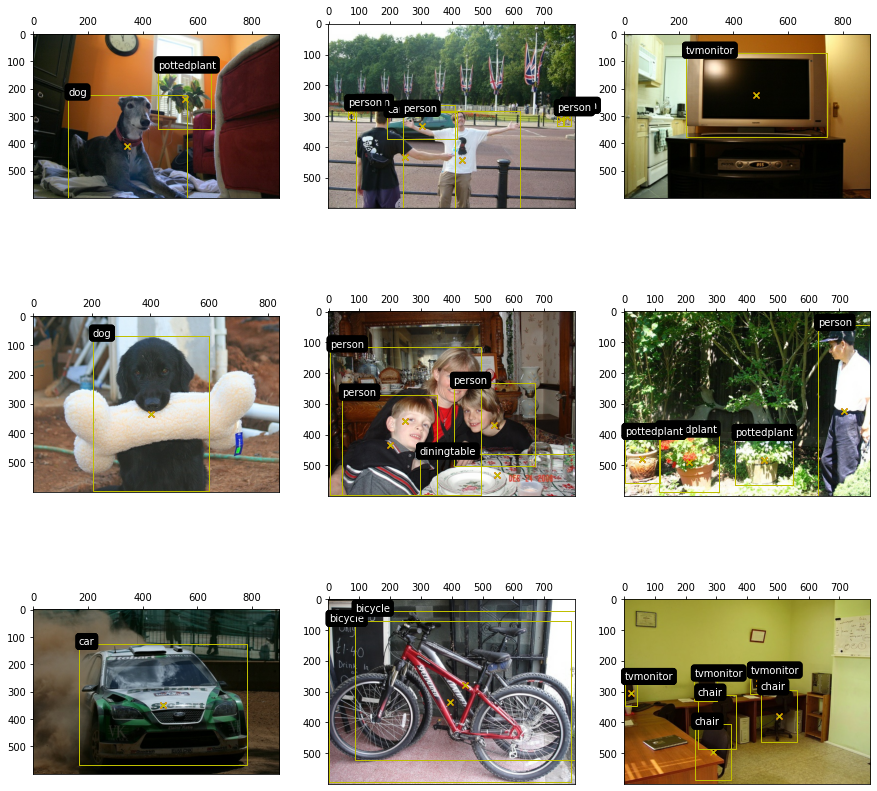

In [16]:
# TESTING:
#   - test rcnn bounding box plotting
sample = next(iter(test_ds.take(1)))
fig, axs = plt.subplots(3,3,figsize=(15,15)); axs = axs.flatten()
for ax,sample in zip(axs,test_ds.take(9)):
    plot_rcnn_bboxes(**sample, ax=ax, plot_centers=True,
                     pred_bboxes=sample['bboxes'], pred_labels=sample['labels'])

### Shared body:
- The first network to process the images and produce features that are then fed into the RPN and Classifier head
- Pretrained on ImageNet
- Archecture of network will determine the receptive field size given the n x n sliding window over the feature layer's outputs

In [17]:
def get_pretrained_network(nw_name='VGG'):
    """ Return a ready-to-run pretrained network.
        Top of network is removed. Trained on 'imagenet'.
        Network weights set to un-trainable.
        Options:
            'VGG': VGG-16 - conv3_1 and up is trainable
    """
    if nw_name == 'VGG':
        pretrained = tf.keras.applications.vgg16.VGG16(
            include_top = False, weights='imagenet'
        )
        # Test dropping the last max pool layer
        pretrained = keras.Model(inputs=pretrained.inputs,
                                 outputs=pretrained.layers[-2].output)
        # 8th layer in conv3_1
        for layer in pretrained.layers[:7]:
            layer.trainable = False
    else:
        assert False, f"Network not available: nw_name={nw_name}"
    return pretrained

In [18]:
pretrained = get_pretrained_network()

58900480/58889256 [==============================] - 0s 0us/step


In [19]:
# TESTING:
#   - according to paper an image of 1000x600 produces 
#     feature of ~60x40
test_image = tf.zeros((1,1000,600,3))
test_output = pretrained(test_image)
print(test_output.shape)

(1, 62, 37, 512)


In [20]:
# TESTING:
#   - test the pretrained network
pretrained = get_pretrained_network('VGG')
for sample in train_ds.take(2):
    image = sample['image']
    bboxes = sample['bboxes']
    labels = sample['labels']
    print("Image shape:", image.shape)
    print(f"Expected output shape (approx.): (1, {round(image.shape[0]/32.)}, {round(image.shape[1]/32.)}, 512)")
    features = pretrained(image[tf.newaxis, ...])
    print("Pretrained output shape:", features.shape)
    print()

Image shape: (740, 600, 3)
Expected output shape (approx.): (1, 23, 19, 512)
Pretrained output shape: (1, 46, 37, 512)

Image shape: (600, 800, 3)
Expected output shape (approx.): (1, 19, 25, 512)
Pretrained output shape: (1, 37, 50, 512)



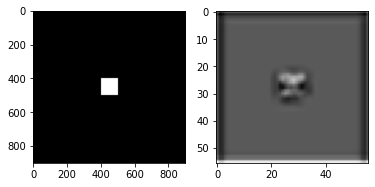

In [21]:
# TESTING:
#   - NOTE: Not a true method of determining receptive field size
#   - Determine receptive field size:
size = 100
test = np.ones((size,size))
test = np.pad(test, 500-size)
test = np.repeat(test[..., np.newaxis], 3, axis=2)

fig, ax = plt.subplots(1,2); ax = ax.flatten()
ax[0].imshow(test)
testout = pretrained(test[np.newaxis, ..., np.newaxis])
ax[1].imshow(tf.reduce_sum(testout[0], axis=-1), cmap='gray')

In [22]:
# Approximate method of determining receptive field size:
#   - appears that ratio is 3:100 for receptive:base pixels
#   - need better method for determining since paper gives ratio of 3:228
test_image_1 = tf.zeros((1, 100, 100, 3))
test_image_2 = tf.zeros((1, 1000, 1000, 3))

out_1 = pretrained(test_image_1)
out_2 = pretrained(test_image_2)

print(out_1.shape)
print(out_2.shape)

#basetoreceptive = 3/100.
basetoreceptive = 3/228.

(1, 6, 6, 512)
(1, 62, 62, 512)


### RPN
- considers provided anchors
- proposes based off of IoU limits

In [23]:
class RPN(keras.Model):
    """ Region-Proposal-Network (RPN).
        Takes features of ONE image as input.
        Produces regression bounding box predictions
            and objectness predictions for each anchor
            across the feature map grid.
            (ie. feat_H x feat_W x k(=9))

    """
    def __init__(self, n=3, k=9):
        super(RPN, self).__init__()

        self.k = k
        self.n = n

        self.initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01, seed=1337)
        self.windowmap = layers.Conv2D(512, (n,n), activation="relu",
                                       padding='same', name="windowmap",
                                       kernel_initializer=self.initializer)
        self.reglayer = layers.Conv2D(4*k, (1,1), activation="relu",
                                      padding='same', name="reglayer",
                                      kernel_initializer=self.initializer)
        self.clslayer = layers.Conv2D(2*k, (1,1), activation="sigmoid",
                                      padding='same', name="clslayer",
                                      kernel_initializer=self.initializer)
        
    def clsloss(self, p, p_tar):
        """ Binary cross-entropy loss for 'objectness' prediction.

            2 Classes: 'is object' and 'is not object'
                - NOTE: Classes aren't mutually exclusive as
                    'neither' will be possible classification
                    later down the line.
        """
        loss = keras.losses.BinaryCrossentropy(p, p_tar)
        return loss

    def call(self, image_features):
        """ RPN Forward Pass.

            Inputs:
                - image_features (tf.float32) :: (1, None(feat_H), None(feat_W), 512)

            Outputs:
                - reg (tf.float32) :: (None(feat_H), None(feat_W), 4)
                - cls (tf.float32) :: (None(feat_H), None(feat_W), 2)
        """
        x = self.windowmap(image_features)

        reg = self.reglayer(x)
        regshape = tf.shape(reg)
        reg = tf.reshape(reg, (regshape[1], regshape[2], 9, 4))

        cls = self.clslayer(x)
        clsshape = tf.shape(cls)
        cls = tf.reshape(cls, (clsshape[1], clsshape[2], 9, 2))

        return [reg, cls]

In [24]:
# TESTING:
#   - test the RPN network
rpn = RPN()
reg, cls = rpn(features)
print(features.shape)
print(reg.shape) # Note: total of W*H*k anchors
print(cls.shape)

(1, 37, 50, 512)
(37, 50, 9, 4)
(37, 50, 9, 2)


#### IoU Rules:
- Since the output of the network (reg) will correspond each anchor w/ ONE object, each anchor needs to be associated with each ground truth box until the point of calculating the loss specifically.
- Anchor labels format :: (H, W, k, #gtruthbboxes, 2)
- Positive:
    - (i) If IoU > 0.7 w/ ANY gtruth bbox
    - ELSE IF NONE of anchors IoU > 0.7 w/ ANY gtruth bbox
    - (ii) Anchor/Anchors w/ highest IoU w/ ANY gtruth bbox
    - Note: It is possible for a set of anchors to have passed to (ii) where at least one of the anchors is flagged Positive w/ IoU < 0.3
- Negative:
    - (i) IF NON-POSITIVE anchor AND IF IoU < 0.3 for ALL gtruth bboxes
- Neither:
    - Ignore during training

#### Compartmentalized methods

In [25]:
def parameterize_rcnn_bbox(input_bbox, anchor_bbox):
    """ Parameterize the RCNN bounding box into paper-specified format,
        using the RCNN anchor bounding box.

        Note: The parameterization is scale/translation-invariant
            meaning the input values could be normalized or not.
            However, both bounding boxes must have matching norm status.

        RCNN: (center_x, center_y, width, height)
        Parameterization: *Lookup Faster-RCNN paper*
    """
    center_x, center_y, width, height = tf.split(input_bbox, num_or_size_splits=4, axis=-1)
    center_x_a, center_y_a, width_a, height_a = tf.split(anchor_bbox, num_or_size_splits=4, axis=-1)
    width = width + 1e-10   # Add epsilon for log(0) prevention
    height = height + 1e-10 #   No worries about log(neg) since input will be relu'd in prev. step
    
    tx = (center_x - center_x_a) / width_a
    ty = (center_y - center_y_a) / height_a
    tw = tf.math.log(width / width_a)
    th = tf.math.log(height / height_a)
    return tf.concat([tx, ty, tw, th], axis=-1)

In [26]:
def create_rcnn_anchors(img_H, img_W, feat_H, feat_W,
                        scales=[128., 256., 512.], aspects=[1., .5, 2.]):
    """ Returns anchor bounding boxes, in RCNN format,
        at every point in the feature map grid.
        (ie. feat_H x feat_W x k(=9))

        Requires user to pass img_H/W and feat_H/W.
    """
    # Create set of anchor centers over feat_H x feat_W grid.
    H_linspace = tf.linspace(start=0., stop=1., num=feat_H)
    W_linspace = tf.linspace(start=0., stop=1., num=feat_W)
    anchor_centers = tf.stack(tf.meshgrid(W_linspace, H_linspace), axis=-1) # :: (feat_H, feat_W, 2)
    
    # Create set of anchor heights/widths for all k anchors.
    anchor_W, anchor_Hscales = tf.meshgrid(scales, aspects) # Create all possible combinations of scales + aspects
    anchor_H = anchor_W * anchor_Hscales
    anchor_W_H = tf.stack([anchor_W, anchor_H], axis=-1)
    anchor_W_H = tf.reshape(anchor_W_H, [-1, 2]) # :: (k,2)
    anchor_W_H = anchor_W_H * tf.stack([1./tf.cast(img_W, tf.float32),
                                        1./tf.cast(img_H, tf.float32)])
    
    # Get complete relative sized anchor bboxes 4 coords
    k = len(scales) * len(aspects) # = 9
    # anchor_centers :: (feat_H, feat_W, 2) --> (feat_H, feat_W, k, 2)
    # anchor_W_H :: (k, 2) --> (feat_H, feat_W, k, 2)
    # anchor_rcnn_bboxes :: (feat_H, feat_W, k, 4)
    anchor_centers = tf.broadcast_to(anchor_centers[:, :, tf.newaxis, :], shape=[feat_H, feat_W, k, 2])
    anchor_W_H = tf.broadcast_to(anchor_W_H, shape=[feat_H, feat_W, k, 2])
    anchor_rcnn_bboxes = tf.concat([anchor_centers, anchor_W_H], axis=-1)

    return anchor_rcnn_bboxes, anchor_W_H[0, 0, :, :]

(37, 50, 9, 4)
(1850, 4)


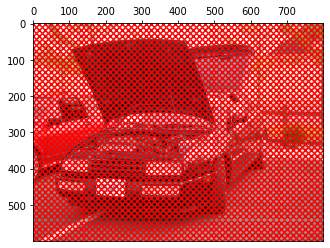

In [27]:
# TESTING:
#   - test creation of rcnn anchors
img_H, img_W, _ = image.shape
_, feat_H, feat_W, _ = features.shape
rcnn_anchors, _ = create_rcnn_anchors(img_H, img_W, feat_H, feat_W,
                                      scales=[128., 256., 512.], aspects=[1., .5, 2.])
print(rcnn_anchors.shape)
rcnn_anchors = rcnn_anchors[:, :, 0, :]
rcnn_anchors = tf.reshape(rcnn_anchors, [-1,4])
print(rcnn_anchors.shape)
plot_rcnn_bboxes(image, rcnn_anchors, None, plot_centers=True, plot_boxes=False)

In [28]:
def generate_crossbound_mask(anchor_voc_bboxes):
    """ Generate cross-boundary anchor mask for network
        to ignore samples during training.

        Since VOC values are normalized b/w [0,1],
        can check cross-bounds with >1. and <0.

        VOC: (ymin, xmin, ymax, xmax)
        Output Flags: 
            - TRUE if bounding box does NOT cross boundary
            - FALSE if bounding box crosses boundary
    """
    crossbounds_mask = (anchor_voc_bboxes > 1.) | (anchor_voc_bboxes < 0.) # :: (..., 4)
    crossbounds_mask = tf.reduce_any(crossbounds_mask, axis=-1) # :: (...)
    crossbounds_mask = ~crossbounds_mask
    return crossbounds_mask

In [139]:
def generate_voc_anchor_labels(anchor_voc_bboxes, gtruth_voc_bboxes, crossbound_mask=None):
    """ Generate the labels for the VOC format anchor bounding boxes.
        INCOMPLETE DESCRIPTION
        INCOMPLETE DESCRIPTION
        INCOMPLETE DESCRIPTION
    """
    # Calculate IoU b/w all anchors and all gtruth bboxes:
    #   - Note: L_IoU = 1 - IoU
    num_gt_bboxes = tf.shape(gtruth_voc_bboxes)[0]
    anchor_voc_bboxes = anchor_voc_bboxes[:, :, :, tf.newaxis, :] # :: (feat_H, feat_W, k, 1, 4)
    IoUs = 1. - tfa.losses.giou_loss(gtruth_voc_bboxes, anchor_voc_bboxes, mode='iou') # :: (feat_H, feat_W, k, # of gtruth bboxes)
    # Dimensions are too far reduced if 1 gtruth bbox
    IoUs = tf.cond(num_gt_bboxes == 1, lambda: IoUs[..., tf.newaxis], lambda: IoUs)
    
    # Flag the anchors according to IoU
    #   - '_pergt' :: (feat_H, feat_W, k, # of gtruth bboxes)
    #       - ie. retains info for each gtruth bbox wrt each anchor
    #   - '_anygt' :: (feat_H, feat_W, k)
    #       - ie. condition is true/false wrt ANY of the k anchors
    #   - '_allgt' :: (feat_H, feat_W, k)
    #       0 ie. condition is true/false wrt ALL of the k anchors
    greaterp7_pergt = IoUs > 0.7
    greaterp7_anygt = tf.reduce_any(greaterp7_pergt, axis=-1) # (i)
    lesserp3_pergt  = IoUs < 0.3
    lesserp3_allgt = tf.reduce_all(lesserp3_pergt, axis=-1)
    
    # Maximum IoU across all k anchors (per position) and all gtruth bboxes
    #   - flag each anchor true if it equals max iou in anchor set
    maxious = tf.reduce_max(IoUs, axis=[-1,-2]) # :: (feat_H, feat_W)
    maxiousflags = (maxious[..., tf.newaxis, tf.newaxis] == IoUs) # :: (featu_H, feat_W, k, # of gtruth bboxes)
    
    # Below handles the two positive cases
    #   - Note: python bitwise operators work as logical operators w/ tf bools
    #   - positiveflags(_anygt/_pergt) :: (feat_H, feat_W, k[, # of gtruth bboxes])
    #   - negativeflags(_allgt/_pergt) :: (feat_H, feat_W, k[, # of gtruth bboxes])
    
    # "Anchor is positive if IoU > 0.7 OR none of the anchors in the set have IoU > 0.7 but have max IoU for the set"
    #   - corresponds to cond. for Positive (i)/(ii)
    #   - APPLY crossbound masking
    positiveflags_pergt = greaterp7_pergt | (~greaterp7_anygt[..., tf.newaxis] & maxiousflags)
    if crossbound_mask is not None: 
        positiveflags_pergt = crossbound_mask[..., tf.newaxis] & positiveflags_pergt
    positiveflags_anygt = tf.reduce_any(positiveflags_pergt, axis=-1)
    
    # "Anchor is negative if none of the anchors in the set are positive AND the IoU < 0.3 for all gtruth bboxes"
    #   - corresponds to cond. for Negative (i)
    #   - APPLY crossbound masking
    #   - Note: a corrolary to the rules is that IFF ANY anchor in the set is negative, ALL will be negative 
    negativeflags_allgt = ~tf.reduce_any(positiveflags_anygt, axis=-1)[..., tf.newaxis] & lesserp3_allgt 
    if crossbound_mask is not None: 
        negativeflags_allgt = crossbound_mask & negativeflags_allgt
    negativeflags_pergt = tf.repeat(negativeflags_allgt[..., tf.newaxis], num_gt_bboxes, axis=3)
    
    # "Anchor is neither positive nor negative"
    #   - corresonds to cond. for Neither
    neitherflags_pergt = ~positiveflags_pergt & ~negativeflags_pergt

    return (IoUs, positiveflags_pergt, positiveflags_anygt, negativeflags_allgt, negativeflags_pergt, neitherflags_pergt)

In [144]:
def anchor_flag_debugging(sample, gtruth_n):
    image = sample['image']
    bboxes = sample['bboxes']
    labels = sample['labels']

    gtruth_cnt = bboxes.shape[0]
    print(f"# Gtruth: {gtruth_cnt}")

    features = pretrained(image[tf.newaxis, ...])

    img_H, img_W, _ = image.shape
    _, feat_H, feat_W, _ = features.shape
    rcnn_anchors, anchor_W_H = create_rcnn_anchors(img_H, img_W, feat_H, feat_W,
                                                   scales=[128., 256., 512.], aspects=[1., .5, 2.])
    
    voc_anchors = rcnn_to_voc_bbox(rcnn_anchors)
    mask = generate_crossbound_mask(voc_anchors)

    voc_gtruth = rcnn_to_voc_bbox(bboxes)
    (IoUs, 
     pflags_per, 
     pflags_any, 
     nflags_all, 
     nflags_per, 
     neitherflags_per) = generate_voc_anchor_labels(voc_anchors, voc_gtruth, crossbound_mask=mask)

    fig, axs = plt.subplots(7,9,figsize=(24,12)); axs = axs.flatten()
    axs[0].set_ylabel(f"Gtruth #{gtruth_n+1} of {gtruth_cnt}")
    for i in range(9):
        plot_rcnn_bboxes(image, bboxes, None, ax=axs[i], plot_centers=True,
                         IoUs = IoUs[:, :, i, gtruth_n:gtruth_n+1])
        axs[i].set_title(f"({tf.cast(anchor_W_H[i, 0] * img_W, tf.int32)}, {tf.cast(anchor_W_H[i, 1] * img_H, tf.int32)})")
        axs[i].set_xlabel(f"Max IoU: {tf.reduce_max(IoUs[:, :, i, gtruth_n:gtruth_n+1]).numpy():.2f}")

    ylabels = ["Crossbound_mask", "Pflags_pergt", "Pflags_anygt", "Nflags_allgt", "Nflags_pergt", "Neitherflags_pergt"]
    ims = [mask, pflags_per[..., gtruth_n], pflags_any, nflags_all, nflags_per[..., gtruth_n], neitherflags_per[..., gtruth_n]]

    for j,(im,ylabel) in enumerate(zip(ims,ylabels)):
        axs[(j+1)*9].set_ylabel(ylabel)
        for i in range(9):
            axs[i+(j+1)*9].imshow(im[..., i], vmin=0, vmax=1)

In [145]:
#print(f"Total anchors: {total_cnt}")
#print(f"Inbounds anchors: {inbounds_cnt}")
#print(f"Percent inbounds: {inbounds_cnt/total_cnt*100.}")

# Gtruth: 2


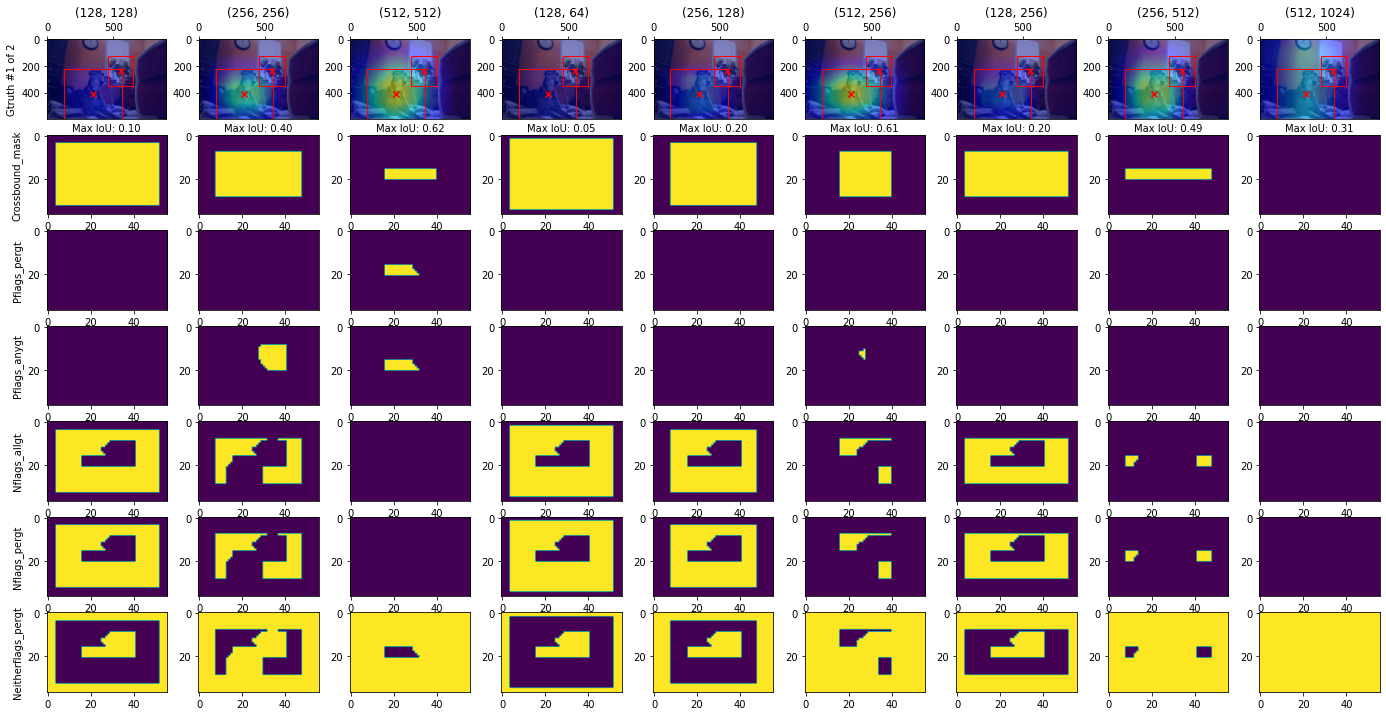

In [158]:
anchor_flag_debugging(get_sample(0, 'test'), 0)

# Gtruth: 2


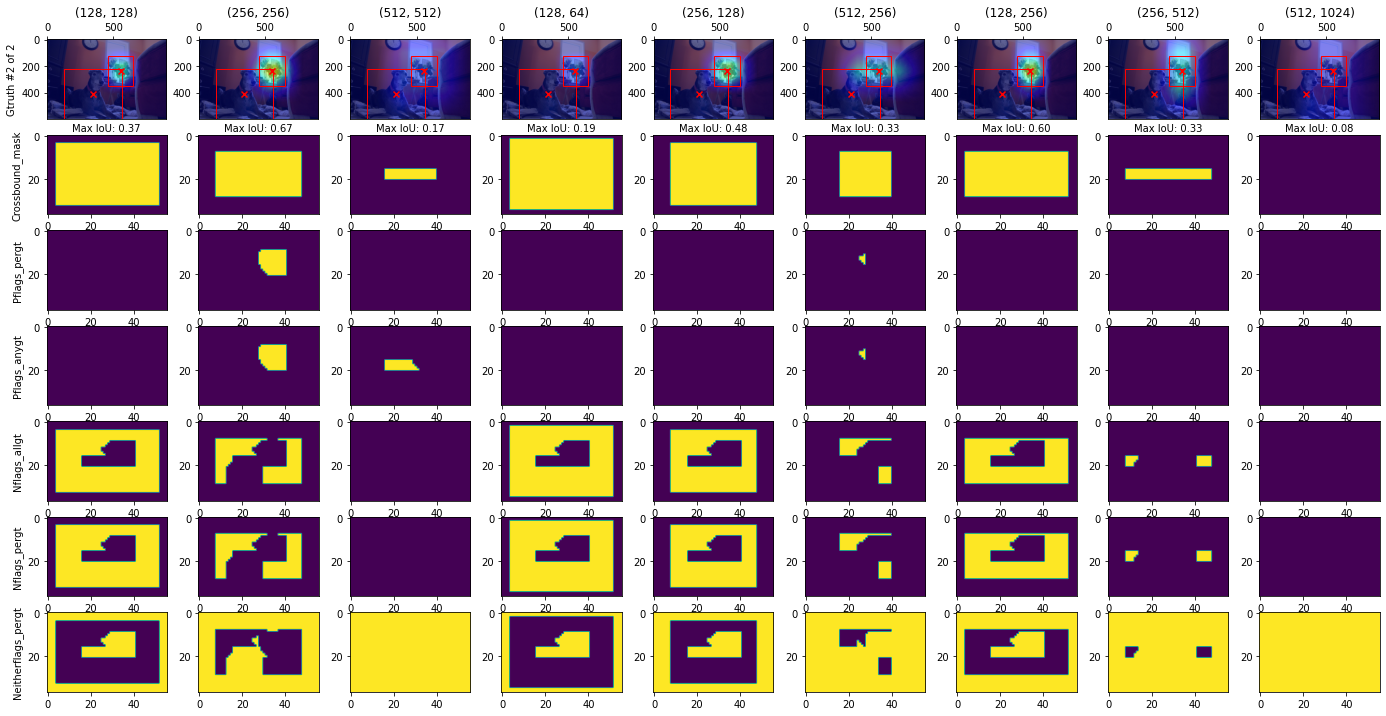

In [160]:
anchor_flag_debugging(get_sample(0, 'test'), 1)

In [148]:
def calc_reg_loss(reg_paramtzd, gtruth_paramtzd):
    """ Calculate the regression loss between
        the paramterized RPN bounding box proposals and
        the parameterized ground truth bounding boxes.

        Note: Paper specifies 'Robust Loss (L1)' though
            'Huber Loss' appears close enough.
    """
    reg_loss = keras.losses.huber(gtruth_paramtzd, reg_paramtzd)
    reg_loss = tf.reduce_mean(reg_loss)
    return reg_loss

In [149]:
def calc_cls_loss(cls, sampled_indices,
                  pos_samples_cnt, neg_samples_cnt):
    """ Calculate the binary cross-entropy loss between
        the RPN 'objectness' predictions for each proposal and
        the true 'objectness' that was assigned to each anchor.

        Note: The true 'objectness' was assigned to each anchor
            based off of the ground truth bounding boxes in 
            previous steps, according to the IoU rules.
    """
    # Note: can drop 4th index in indices since cls not gtruth specific
    cls_sampled = tf.gather_nd(cls, sampled_indices[:, :3])
    cls_tar_pos = tf.repeat([[1.,0.]], pos_samples_cnt, axis=0)
    cls_tar_neg = tf.repeat([[0.,1.]], neg_samples_cnt, axis=0)
    cls_tar = tf.concat([cls_tar_pos, cls_tar_neg], axis=0)
    cls_loss = keras.losses.binary_crossentropy(cls_tar,
                                                cls_sampled,
                                                from_logits=False)
    cls_loss = tf.reduce_mean(cls_loss)
    return cls_loss

In [150]:
def gather_minibatch(positiveflags_pergt, negativeflags_pergt,
                     reg_paramtzd, gtruth_paramtzd,
                     desired_total=256, desired_positive=128):
    """ Gather the minibatch of bounding box proposals for training, per image.
    """
    # Implementation of mini-batch random sampling of 256 anchors
    #   - Note: still wrt each ground truth
    num_pos_samples = tf.reduce_sum(tf.cast(positiveflags_pergt, tf.int32))
    pos_samples_cnt = tf.math.minimum(desired_positive, num_pos_samples)
    neg_samples_cnt = desired_total - pos_samples_cnt
    
    # Randomly sample positive flag indices
    pos_indices = tf.where(positiveflags_pergt)
    pos_indices = tf.random.shuffle(pos_indices, 
                                    seed=1337, 
                                    name="Minibatch_sampling_pos")
    pos_indices = pos_indices[:pos_samples_cnt]
    
    # Randomly sample neg flag indices
    neg_indices = tf.where(negativeflags_pergt)
    neg_indices = tf.random.shuffle(neg_indices,
                                    seed=1337,
                                    name="Minibatch_sampling_neg")
    neg_indices = neg_indices[:neg_samples_cnt]

    # In case there aren't enough negative samples to pad to desired mini-batch size
    neg_samples_cnt = tf.math.minimum(neg_samples_cnt, tf.shape(neg_indices)[0])
    
    # Sample gtruth_paramtzd and reg_paramtzd according to indices
    #   - Note: don't need 4th index when gathering RPN reg output since
    #       the output is the same for all gtruths (ie. not gtruth specific)
    #       - ie. the network doesnt output a bbox per gtruth, only per anchor
    sampled_indices = tf.concat([pos_indices, neg_indices], axis=0)
    gtruth_paramtzd = tf.gather_nd(gtruth_paramtzd, sampled_indices)
    reg_paramtzd = tf.gather_nd(reg_paramtzd, sampled_indices[:, :3])

    return (reg_paramtzd, gtruth_paramtzd, sampled_indices, pos_samples_cnt, neg_samples_cnt)

In [151]:
def get_class_tar(labels, sampled_indices, pos_samples_cnt):
    """ Return the target class associated with each bounding box
        the respective RPN proposed bounding box is being regressed to.
    """
    # sampled_indices format is: (feat_H, feat_W, k, # gtruth box)
    #   - sampled_indices :: (# of samples, 4)
    #   - for class_tar, we only care about the gtruth box index
    pos_sampled_indices = sampled_indices[:pos_samples_cnt]
    class_tar = tf.gather_nd(labels, pos_sampled_indices[:, 3:4])
    return class_tar

#### Combined methods

In [168]:
def get_rpn_bboxes_and_losses(reg, cls, features, labels,
                              img_H, img_W,
                              gtruth_rcnn_bboxes):
    """ DESCRIPTION INCOMPLETE
        DESCRIPTION INCOMPLETE
        DESCRIPTION INCOMPLETE
    """
    # Note: gtruth bboxes from dataset are in rcnn format
    #   - DEBUG: Inconvenient if axes match - hard set to 3
    #gtruth_rcnn_bboxes = gtruth_rcnn_bboxes[:3, :] # Leftover from exposed code testing :: (# gtruth bboxes, 4)
    num_gt_bboxes = tf.shape(gtruth_rcnn_bboxes)[0]
                                
    # Step 1) Generate anchor bboxes
    feat_shape = tf.shape(features)
    feat_H, feat_W = feat_shape[1], feat_shape[2]
    anchor_rcnn_bboxes, _ = create_rcnn_anchors(img_H, img_W, feat_H, feat_W)
    
    # Convert from rcnn format to voc format
    anchor_voc_bboxes = rcnn_to_voc_bbox(anchor_rcnn_bboxes)
    gtruth_voc_bboxes = rcnn_to_voc_bbox(gtruth_rcnn_bboxes)
    
    # Step 2) Generate anchor labels
    #   - w/ Optional cross-bound masking
    crossbound_mask = generate_crossbound_mask(anchor_voc_bboxes)
    #crossbound_mask = None

    (_, # IoUs
     positiveflags_pergt, positiveflags_anygt, 
     negativeflags_allgt, negativeflags_pergt, 
     neitherflags_pergt) = generate_voc_anchor_labels(anchor_voc_bboxes, gtruth_voc_bboxes, crossbound_mask)
    
    # Step 3) Parameterize reg output and gtruth bboxes 
    reg_paramtzd = parameterize_rcnn_bbox(reg, anchor_rcnn_bboxes)
    gtruth_paramtzd = parameterize_rcnn_bbox(gtruth_rcnn_bboxes, anchor_rcnn_bboxes[:, :, :, tf.newaxis, :])
    
    # Step 4) Randomly sample a mini-batch of training samples
    (reg_paramtzd, gtruth_paramtzd, sampled_indices,
    pos_samples_cnt, neg_samples_cnt) = gather_minibatch(positiveflags_pergt, negativeflags_pergt,
                                                        reg_paramtzd, gtruth_paramtzd)
    
    # Step 5) Get target class of the sampled rois
    class_tar = get_class_tar(labels, sampled_indices, pos_samples_cnt)
    
    # Step 6) Calculate reg + cls loss and combine
    lambd = 1.0
    reg_loss = calc_reg_loss(reg_paramtzd, gtruth_paramtzd)
    cls_loss = calc_cls_loss(cls, sampled_indices, pos_samples_cnt, neg_samples_cnt)
    #total_loss = cls_loss + lambd * reg_loss
    
    return reg_paramtzd[:pos_samples_cnt], class_tar, {"cls_loss": cls_loss, "reg_loss": reg_loss}, pos_samples_cnt, neg_samples_cnt

In [169]:
image, bboxes, labels = get_sample(0, 'train').values()
features = pretrained(image[tf.newaxis,...])
reg, cls = rpn(features)
img_H, img_W, _ = tf.shape(image)
(rpn_proposals, 
 class_tar, 
 losses,
 pos_samples_cnt,
 neg_samples_cnt) = get_rpn_bboxes_and_losses(reg, cls, features, labels,
                                     img_H, img_W,
                                     bboxes)
print(rpn_proposals.shape, class_tar.shape)

(128, 4) (128,)


In [ ]:
#
# IMPORTANT ** DON'T DELETE
#

## Paper gives example of 1000x600 input w/ 60x40x9 ~ 20,000 anchors
##   where 6,000 are not cross-boundary (ie. 6000/20000 = 30% valid)
#a = tf.reduce_prod(tf.shape(crossbounds_mask))
#b = tf.reduce_sum(tf.cast(crossbounds_mask, tf.int32))
#print(image.shape)
#print(features.shape)
#print(a.numpy(), b.numpy(), (b / a).numpy())

In [ ]:
reg.shape, cls.shape

(TensorShape([37, 50, 9, 4]), TensorShape([37, 50, 9, 2]))

In [ ]:
N = 10
vals, indices = tf.math.top_k(tf.reshape(cls[..., 0], [-1]), k=N)
obj_reg = tf.gather_nd(tf.reshape(reg, [-1, 4]), indices[...,tf.newaxis])

In [ ]:
print_bbox_formats()

Axis: x -> left-right; y -> up-down
Reference frame (x,y): top-left = (0,0); bot-right = (img_W,img_H)
*All values normalized b/w [0,1]*
VOC:    (ymin, xmin, ymax, xmax)
RCNN:   (center_x, center_y, width, height)
Pyplot: (xmin, ymin, width, height)


TensorShape([600, 800, 3])

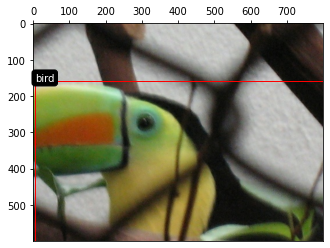

In [ ]:
plot_rcnn_bboxes(image, bboxes, labels, show_labels=True,
                 pred_bboxes=obj_reg, pred_labels=None)
image.shape

In [ ]:
print_bbox_formats()

Axis: x -> left-right; y -> up-down
Reference frame (x,y): top-left = (0,0); bot-right = (img_W,img_H)
*All values normalized b/w [0,1]*
VOC:    (ymin, xmin, ymax, xmax)
RCNN:   (center_x, center_y, width, height)
Pyplot: (xmin, ymin, width, height)


### RoI Pooling

In [ ]:
# Inputs:
#   - RPN BBoxes (reg -- rcnn format)
#   - Features (from shared feature extractor network (VGG) )
#
# Outputs:
#   - RoI Feature Vectors


class RoIPool(keras.Model):
    def __init__(self):
        super(RoIPool, self).__init__()

        self.initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01, seed=1337)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(32, kernel_initializer=self.initializer)
        self.fc2 = layers.Dense(64, kernel_initializer=self.initializer)

        self.crop_height = 64
        self.crop_width  = 64

    def crop_rois(self, reg, features):
        # reg :: (N(=10), 4) -- rcnn format
        # features :: (1, feat_H, feat_W, 512)

        # crop_and_resize:
        #   - expects bbox coords in (ymin, xmin, ymax, xmax) VOC format
        #   - expects bbox coords to be normalized [0,1]
        #   - box_indices refer to which element in batch, only one elem. so 0 
        voc_reg = rcnn_to_voc_bbox(reg)
        box_indices = tf.zeros([tf.shape(reg)[0]], tf.int32)
        crop_size = [self.crop_height, self.crop_width]
        rois_cropped_and_resized = tf.image.crop_and_resize(image=features, 
                                                            boxes=voc_reg,
                                                            box_indices=box_indices,
                                                            crop_size=crop_size)
        return rois_cropped_and_resized
        
    def pool_rois(self, rois):
        # rois :: (N(=10), crop_height, crop_width, 512)
        # pooled_roi :: (N(=10), 7, 7, 512)

        ksize = [self.crop_height // 7, self.crop_width // 7]
        strides = ksize
        padding = "SAME"

        rois_pooled = tf.nn.max_pool2d(input=rois,
                                       ksize=ksize,
                                       strides=strides,
                                       padding=padding)
        return rois_pooled

    def call(self, inputs):
        # inputs -- [features, obj_reg]
        # image_features :: (1, None, None, 512)
        # obj_reg :: (~2000, 4)
        features, obj_reg = inputs
        rois_cropped_and_resized = self.crop_rois(obj_reg, features)
        rois_pooled = self.pool_rois(rois_cropped_and_resized)

        x = self.flatten(rois_pooled) # :: (~2000, 7 * 7 * 512)
        x = self.fc1(x)
        x = self.fc2(x)
        return x # :: (~2000, 64)

In [ ]:
roipool = RoIPool()
# NOTE: Should be passing all positive flagged reg's to the classifier
#   - should be ~2000 rois, if too many, implement NMS
res = roipool([features, obj_reg])
res.shape

TensorShape([10, 64])

### Classifier

In [ ]:
inputs = keras.Input(shape=(64))
# 20 classes in VOC
output = layers.Dense(20, activation="softmax",
                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.01, seed=1337))(inputs)
# Note: could also include an additional bbox regressor
#   as is the case in Fast RCNN
headclassifier = keras.Model(inputs=inputs, outputs=output)

In [ ]:
headclassifier(res)[:2]

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[0.0500175 , 0.04988911, 0.04984792, 0.04981916, 0.05014117,
        0.05007796, 0.05008573, 0.04983181, 0.05002782, 0.05010363,
        0.05024744, 0.04983039, 0.04994107, 0.05029799, 0.04950436,
        0.05024686, 0.04996107, 0.04981072, 0.05016999, 0.05014832],
       [0.0500175 , 0.04988911, 0.04984792, 0.04981916, 0.05014117,
        0.05007796, 0.05008573, 0.04983181, 0.05002782, 0.05010363,
        0.05024744, 0.04983039, 0.04994107, 0.05029799, 0.04950436,
        0.05024686, 0.04996107, 0.04981072, 0.05016999, 0.05014832]],
      dtype=float32)>

In [ ]:
labels

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>

In [ ]:
def calc_head_loss(class_tar, class_pred):
    head_loss = keras.losses.sparse_categorical_crossentropy(class_tar, class_pred, from_logits=False)
    head_loss = tf.reduce_mean(head_loss)
    return head_loss

### Full Model

In [ ]:
class FasterRCNN(keras.Model):
    def __init__(self):
        super(FasterRCNN, self).__init__()
        self.base = pretrained
        self.rpn = RPN()
        self.roipool = RoIPool()
        self.headclassifier = headclassifier

    def call(self, data):
        # data -- {"bboxes":..., "image":..., "labels":...}
        # input_image :: (1, img_H, imgW, 3)
        input_image = data["image"][tf.newaxis,...]
        # features :: (1, feat_H, feat_W, 512)
        features = self.base(input_image)
        # reg :: (feat_H, feat_W, k, 4)
        # cls :: (feat_H, feat_W, k, 2)
        reg, cls = self.rpn(features)
        pos_reg = tf.gather_nd(reg, tf.where(cls[..., 0] > 0.5))
        # TODO: NMS 
        pos_reg = pos_reg[:100]
        # roifeaturevectors
        roifeaturevectors = self.roipool([features, pos_reg])
        # classpreds
        class_preds = self.headclassifier(roifeaturevectors)

        return pos_reg, class_preds

    def main_body(self, input_image, img_H, img_W, gtruth_labels, gtruth_voc_bboxes):
         # features :: (1, feat_H, feat_W, 512)
        features = self.base(input_image)

        # reg :: (feat_H, feat_W, k, 4)
        # cls :: (feat_H, feat_W, k, 2)
        reg, cls = self.rpn(features)

        # Get proposed bboxes and losses
        #   - TODO: Include NMS to reduce overlapping proposals
        lambd = 1.0
        (rpn_pred_bboxes, 
            class_tar, 
            losses,
            pos_samples_cnt,
            neg_samples_cnt) = get_rpn_bboxes_and_losses(reg, cls, features, gtruth_labels,
                                                        img_H, img_W,
                                                        gtruth_voc_bboxes)
        cls_loss, reg_loss = losses["cls_loss"], losses["reg_loss"]
        rpn_loss = cls_loss + lambd * reg_loss

        # If no positive samples, can skip head classifier
        head_loss = tf.constant(0.0)
        if pos_samples_cnt != 0:
            # bboxes :: (~2000, 4)
            # roifeaturevectors:: (~2000, 64)
            roifeaturevectors = self.roipool([features, rpn_pred_bboxes])
    
            # class_preds :: (~2000, 1000)
            class_preds = self.headclassifier(roifeaturevectors)

            # calc. head classifier loss
            head_loss = calc_head_loss(class_tar, class_preds)
        # If pos samples exist, include head classifier loss
        loss = rpn_loss + head_loss
        return reg_loss, cls_loss, head_loss, loss


    @tf.function
    def train_step(self, data):
        # data -- {"bboxes":..., "image":..., "labels":...}
        # input_image :: (1, img_H, imgW, 3)
        # gtruth_voc_bboxes :: (# gtruth bboxes, 4)
        input_image = data["image"][tf.newaxis,...]
        gtruth_voc_bboxes = data["bboxes"]
        gtruth_labels = data["labels"]
        img_shape = tf.shape(input_image)
        img_H, img_W = img_shape[1], img_shape[2]

        with tf.GradientTape() as tape:
            all_losses = self.main_body(input_image, img_H, img_W, gtruth_labels, gtruth_voc_bboxes)
            reg_loss, cls_loss, head_loss, loss = all_losses
        
        # Calc. gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        #self.compiled_metrics.update_state(y, y_pred)

        # Return a dict mapping metric names to current value
        #   - return metrics values for use in progress bar and callbacks
        return {"reg_loss": reg_loss, 
                "cls_loss": cls_loss, 
                "head_loss": head_loss, 
                "total_loss": loss}

    @tf.function
    def test_step(self, data):
        # data -- {"bboxes":..., "image":..., "labels":...}
        # input_image :: (1, img_H, imgW, 3)
        # gtruth_voc_bboxes :: (# gtruth bboxes, 4)
        input_image = data["image"][tf.newaxis,...]
        gtruth_voc_bboxes = data["bboxes"]
        gtruth_labels = data["labels"]
        img_shape = tf.shape(input_image)
        img_H, img_W = img_shape[1], img_shape[2]

        all_losses = self.main_body(input_image, img_H, img_W, gtruth_labels, gtruth_voc_bboxes)
        reg_loss, cls_loss, head_loss, loss = all_losses

        # Update metrics
        #self.compiled_metrics.update_state(y, y_pred)

        # Return a dict mapping metric names to current value
        #   - return metrics values for use in progress bar and callbacks
        return {"reg_loss": reg_loss, 
                "cls_loss": cls_loss, 
                "head_loss": head_loss, 
                "total_loss": loss}

In [ ]:
optimizer = tfa.optimizers.SGDW(weight_decay=0.0005,
                                learning_rate=0.001, 
                                momentum=0.9)
# DEBUGGING: Sample 18 is producing NaN for head_loss
fasterrcnn = FasterRCNN()
fasterrcnn.compile(optimizer=optimizer)
ith_sample = 18
for train_sample in train_ds.take(ith_sample):
    continue
for test_sample in test_ds.take(ith_sample):
    continue
(fasterrcnn.train_step(sample),
fasterrcnn.test_step(sample))

({'cls_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.7083536>,
  'head_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9956064>,
  'reg_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.795989>,
  'total_loss': <tf.Tensor: shape=(), dtype=float32, numpy=11.499949>},
 {'cls_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6977968>,
  'head_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9947774>,
  'reg_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.8481014>,
  'total_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.5406756>})

In [ ]:
fasterrcnn = FasterRCNN()
fasterrcnn.compile(optimizer=optimizer)
for data in train_ds.take(3):
    print([d.shape for d in data.values()])
    print(fasterrcnn.train_step(data))
# RoIPool warning because head classifier loss not implemented

[TensorShape([740, 600, 3]), TensorShape([4, 4]), TensorShape([4])]
{'reg_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.7999372>, 'cls_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.70021105>, 'head_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9957564>, 'total_loss': <tf.Tensor: shape=(), dtype=float32, numpy=11.495905>}
[TensorShape([600, 800, 3]), TensorShape([2, 4]), TensorShape([2])]
{'reg_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.1916423>, 'cls_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.7028971>, 'head_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.995884>, 'total_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.890423>}
[TensorShape([600, 800, 3]), TensorShape([1, 4]), TensorShape([1])]
{'reg_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5954986>, 'cls_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.7084473>, 'head_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9933064>, 'total_loss': <tf.Tensor: shape=(), dtype=float32,

### Overfit test verification

In [ ]:
overfit_sample = next(iter(train_ds.take(1)))

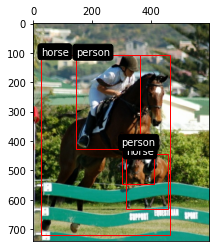

In [ ]:
plot_rcnn_bboxes(**overfit_sample)

In [ ]:
overfit_ds = train_ds.take(1).repeat()

In [ ]:
fasterrcnn = FasterRCNN()
fasterrcnn.compile(optimizer=optimizer)
history = fasterrcnn.fit(overfit_ds, epochs=10,
                         steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 37s 329ms/step - reg_loss: 2.5138 - cls_loss: 0.4584 - head_loss: 2.7389 - total_loss: 5.7111
Epoch 2/10
100/100 [==============================] - 48s 482ms/step - reg_loss: 2.2748 - cls_loss: 0.3791 - head_loss: 1.7009 - total_loss: 4.3548
Epoch 3/10
100/100 [==============================] - 39s 386ms/step - reg_loss: 2.2268 - cls_loss: 0.3002 - head_loss: 1.3886 - total_loss: 3.9156
Epoch 4/10
100/100 [==============================] - 40s 395ms/step - reg_loss: 2.2350 - cls_loss: 0.1433 - head_loss: 1.2184 - total_loss: 3.5967
Epoch 5/10
100/100 [==============================] - 38s 377ms/step - reg_loss: 2.2271 - cls_loss: 0.0600 - head_loss: 1.0490 - total_loss: 3.3362
Epoch 6/10
100/100 [==============================] - 37s 370ms/step - reg_loss: 2.2151 - cls_loss: 0.0338 - head_loss: 0.8346 - total_loss: 3.0835
Epoch 7/10
100/100 [==============================] - 35s 353ms/step - reg_loss: 2.2433 - cls_loss: 0.0324 - hea

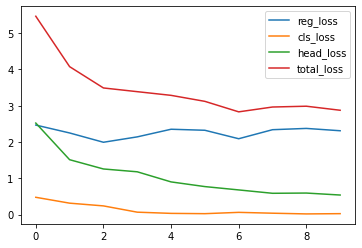

In [ ]:
plot_history(history)

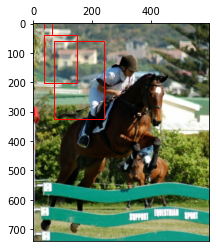

In [ ]:
test_res = fasterrcnn(overfit_sample)
test_res = (test_res[0][:4], test_res[1][:4])
plot_rcnn_bboxes(overfit_sample['image'], test_res[0], test_res[1], show_labels=False)

### Training RPNs:
- Training RPNs
    - stochastic gradient descent
    - each mini-batch arises from single image containing many positive and negative anchors
    - to prevent bias towards the more common negative anchors, randomly sample 256 anchors in image w/ up to 1:1 ratio
        - if fewer than 128 positive samples, pad mini-batch w/ negative ones
    - randomly initialize all new layers by drawing weights form zero-mean Gauss distrib. w/ std of 0.01
        - all other layers (ie. shared conv layers) are initialized by pretraining model for ImageNet classification (ie. fine-tune ZF, VGG, etc.)
    - lr = 0.001 for 60k mini-batches
    - lr = 0.0001 for next 20k mini-batches
    - momentum = 0.9
    - weight decay = 0.000

In [ ]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """ DESCRIPTION INCOMPLETE
    """
    def __init__(self):
        super(CustomLearningRateScheduler, self).__init__()
        self.batch_num = 0

    # Slow to do on every batch?
    def on_train_batch_begin(self, batch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        if self.batch_num > 60000:
            tf.keras.backend.set_value(self.model.optimizer.lr, 0.0001)
            print(f"\nBatch #{self.batch_num}: Learning rate set to 0.0001")
        self.batch_num += 1

In [ ]:
fasterrcnn = FasterRCNN()
fasterrcnn.compile(optimizer=optimizer)
history = fasterrcnn.fit(train_ds, epochs=10,
                         validation_data=valid_ds, validation_steps=250,
                         callbacks=[CustomLearningRateScheduler(),
                                    keras.callbacks.EarlyStopping('val_total_loss', patience=3)])

Epoch 1/10
2501/2501 [==============================] - 449s 178ms/step - reg_loss: 5.1286 - cls_loss: 1.3460 - head_loss: 2.7193 - total_loss: 9.1939 - val_reg_loss: 11.2334 - val_cls_loss: 0.7239 - val_head_loss: 3.0192 - val_total_loss: 14.9765
Epoch 2/10
2501/2501 [==============================] - 347s 139ms/step - reg_loss: 10.4722 - cls_loss: 0.4809 - head_loss: 2.7097 - total_loss: 13.6628 - val_reg_loss: 11.4012 - val_cls_loss: 0.6968 - val_head_loss: 3.0223 - val_total_loss: 15.1204
Epoch 3/10
2501/2501 [==============================] - 355s 142ms/step - reg_loss: 10.3978 - cls_loss: 0.4906 - head_loss: 2.7067 - total_loss: 13.5951 - val_reg_loss: 11.2111 - val_cls_loss: 0.7013 - val_head_loss: 3.0256 - val_total_loss: 14.9381
Epoch 4/10
2501/2501 [==============================] - 348s 139ms/step - reg_loss: 10.2712 - cls_loss: 0.4936 - head_loss: 2.7057 - total_loss: 13.4705 - val_reg_loss: 11.1524 - val_cls_loss: 0.6933 - val_head_loss: 3.0262 - val_total_loss: 14.8719
Ep

In [ ]:
def plot_history(history):
    for name,vals in history.history.items():   
        plt.plot(vals, label=name)
    plt.legend()

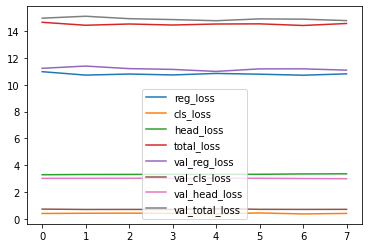

In [ ]:
plot_history(history)

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_weights
fasterrcnn.save_weights(f'saved_weights/{round(time.time())}/fasterrcnn_weights')

## Inference

In [ ]:
# Perform inference
# bboxes_pred :: (# pred. bboxes, 4)
# class_pred :: (# pred. bboxes, # classes(=20))
test_sample = next(iter(test_ds.take(1)))
bboxes_pred, classes_pred = fasterrcnn(test_sample)
# Get top-k based on class confidence
labels_pred = tf.argmax(classes_pred, axis=-1)
labels_pred_val = tf.reduce_max(classes_pred, axis=-1)
# Use NMS
nms_bbox_indices = tf.image.non_max_suppression(bboxes_pred, 
                                                labels_pred_val, 
                                                max_output_size=10)
nms_bbox_indices = nms_bbox_indices[..., tf.newaxis]
nms_bboxes_pred = tf.gather_nd(bboxes_pred, nms_bbox_indices)
nms_labels_pred = tf.gather_nd(labels_pred, nms_bbox_indices)

# Plot results
fig, ax = plt.subplots()
plot_rcnn_bboxes(ax, image, nms_bboxes_pred, nms_labels_pred)

## Training: 4-Step Alternating Training
1. fine-tune pre-trained ImageNet model for RPN
2. train separate detection network by Fast R-CNN using generated proposals from step-1 (also a pre-trained ImageNet model)
3. use detector network to initialize RPN training, but fix the shared conv layers and only fine-tune the layers unique to RPN (now two networks share conv layers)
4. keeping shared layers fixed, fine-tune unique layers of Fast R-CNN


## Training: Approximate joint training
- RPN and Fast RCNN merged into one network
- in each SGD iteration, forward pass generates region proposals which are then passed to the Fast RCNN classifier and are treated as static givens (ie. no backprop path)
- backprop is the usual, where shared layers receive backprop signlas from both RPN loss and Fast RCNN loss, combined
- Note: soln is easy but ignored the derivative wrt the proposal boxes' coordinates that are also network responses, so is approximate
- should produce close results to method 1, but should be faster

## Training: Non-approximate joint training
- since the RoI Pooling Layer in FastRCNN accepts the conv features AND the predicted bounding boxes as inputs, grads should theoretically be valid wrt the box coordinates (ie. TF GradientTape should be able to handle the gradient across the bounding box outputs)
- would mean we need RoI pooling layer that is differentiable wrt the box coordinates (according to author, nontrivial problem)

## Implementation Details:
- re-scale images such that shorter side is s = 600 pixels
- for anchors, use 3 scales w/ box areas of 128^2, 256^2, 512^2 and 3 aspect ratios of 1:1, 1:2, 2:1
    - note that the bbox prediction is allowed to be larger than the underlying anchor in the receptive field
- for anchor boxes that cross image boundaries:
    - during training, ignore so they don't contribute to loss
        - for 1000 x 600 images, roughly 20000 anchors where 6000 are not cross-boundary
    - during testing, clip the proposals that are cross-boundary and return
- to reduce redundancy in overlapping proposals, adopt non-max suppression on proposals based on cls scores.
    - fix IoU thresh for NMS at 0.7, leaving ultimately about 2000 proposal regions per image
    - after NMS, use top-N ranked proposal regions for detection
    - Note: can be more lax during training and more strict during testing

## Experiments:
- Paper performed experiments on the PASCAL VOC detection benchmark
- as well as the MS COCO object detection dataset